In [45]:
from tensorflow.python.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.python.keras.models import Sequential
import tensorflow as tf
from keras.utils import plot_model
from keras.optimizers import SGD, Adam
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
import datetime as dt
import pandas_datareader as pdr
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
register_matplotlib_converters()
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import bollinger_pband
import seaborn as sns
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import sklearn.preprocessing as prep
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
from datetime import datetime
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
yf.pdr_override()

In [26]:
def get_exp_preprocessing(df):
    edata = df.ewm(alpha=0.9).mean()   
    return edata

In [27]:
def preprocesses(data):
    data['pred'] = data['Adj Close']
    predList = []
    y = 0
    for i in data['pred']:
        predList.append(i)

    while y < data.shape[0] -1 :
        diff = predList[y] - predList[y+1]
        if diff > 0:
            predList[y] = 0
        else:
            predList[y] = 1
        y += 1

    data['pred'] = predList
    data = data.drop(['High', 'Low', 'Adj Close'], 1)
    data['Open'] = data['Open'].pct_change() 
    data['Close'] = data['Close'].pct_change() 
    data['Volume'] = data['Volume'].pct_change()
    data = data.dropna()
    return data

In [28]:
def prepare_data(data):
    
    del (data['pred'])
    data = data.dropna()
    return data
    
def split_x_y(data_final):
    Y = data_final['pred'].values
    train_scaled = prepare_data(data_final)
    train_scaled = train_scaled.iloc[1: , :]
    Y = Y[:-1]
    return train_scaled, Y

In [29]:
def scaler(train_scaled):
    min_max = MinMaxScaler((0, 1))
    train_scaled = min_max.fit_transform(train_scaled)
    return train_scaled

In [30]:
def split_train_test(train_scaled, Y):
    factor = 0.80

    length = train_scaled.shape[0]

    total_for_train = int(length*factor)

    X_train = np.array(train_scaled[:total_for_train])
    Y_train = np.array(Y[:total_for_train])
    X_test = np.array(train_scaled[total_for_train:])
    Y_test = np.array(Y[total_for_train:])
    
    return X_train, Y_train, X_test, Y_test

In [32]:
def reshape_3d(X_train,X_test):
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1] ))
    return X_train, X_test

In [33]:

def build_model(X_train, Y_train,X_test, Y_test):
    model=Sequential()
    model.add(tf.keras.layers.LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
    model.add(tf.keras.layers.LSTM(100,return_sequences=True))
    model.add(tf.keras.layers.LSTM(100,return_sequences=True))
    model.add(tf.keras.layers.LSTM(100,return_sequences=False))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])

    history=model.fit(X_train,Y_train,batch_size=64,epochs=100, validation_data=(X_test,Y_test))
   
    return model

In [47]:
start = datetime.strptime('1990-01-01', '%Y-%m-%d')
end = datetime.strptime('2019-1-01', '%Y-%m-%d')
data = pdr.get_data_yahoo("AAPL", start, end)
data_smoothed = get_exp_preprocessing(data)
data_processed = preprocesses(data_smoothed)
X, Y = split_x_y(data_processed)
X_scaled = scaler(X)
X_train, Y_train, X_test, Y_test = split_train_test(X,Y)
X_train, X_test = reshape_3d(X_train, X_test)
model = build_model(X_train, Y_train, X_test, Y_test)


[*********************100%***********************]  1 of 1 completed
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5844 samples, validate on 1461 samples
Epoch 1/100
5844/5844 [==============================] - 2s 297us/sample - loss: 0.4731 - acc: 0.7182 - val_loss: 0.1800 - val_acc: 0.9268
Epoch 2/100
5844/5844 [==============================] - 0s 76us/sample - loss: 0.0915 - acc: 0.9670 - val_loss: 0.0926 - val_acc: 0.9541
Epoch 3/100
5844/5844 [==============================] - 0s 71us/sample - loss: 0.0512 - acc: 0.9764 - val_loss: 0.0632 - val_acc: 0.9822
Epoch 4/100
5844/5844 [==============================] - 0s 75us/sample - loss: 0.0692 - acc: 0.9702 - val_loss: 0.1987 - val_acc: 0.9062
Epoch 5/100
5844/5844 [==============================] - 0s 80us/sample - loss: 0.0411 - acc: 0.9824 - val_loss: 0.0602 - val_acc: 0.9692
Epoch 6/100
5844/

5844/5844 [==============================] - 0s 75us/sample - loss: 0.0113 - acc: 0.9964 - val_loss: 0.0196 - val_acc: 0.9952
Epoch 55/100
5844/5844 [==============================] - 0s 70us/sample - loss: 0.0217 - acc: 0.9916 - val_loss: 0.0280 - val_acc: 0.9904
Epoch 56/100
5844/5844 [==============================] - 0s 80us/sample - loss: 0.0122 - acc: 0.9961 - val_loss: 0.0252 - val_acc: 0.9918
Epoch 57/100
5844/5844 [==============================] - 0s 78us/sample - loss: 0.0202 - acc: 0.9928 - val_loss: 0.0577 - val_acc: 0.9726
Epoch 58/100
5844/5844 [==============================] - 0s 78us/sample - loss: 0.0144 - acc: 0.9942 - val_loss: 0.0469 - val_acc: 0.9760
Epoch 59/100
5844/5844 [==============================] - 0s 73us/sample - loss: 0.0116 - acc: 0.9961 - val_loss: 0.0761 - val_acc: 0.9699
Epoch 60/100
5844/5844 [==============================] - 0s 73us/sample - loss: 0.0143 - acc: 0.9942 - val_loss: 0.0242 - val_acc: 0.9938
Epoch 61/100
5844/5844 [================

In [48]:
model.evaluate(X_test,Y_test)


1461/1461 [==============================] - 0s 39us/sample - loss: 0.0185 - acc: 0.9932


[0.018452255324952045, 0.99315536]

In [49]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            41600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 282,901
Trainable params: 282,901
Non-trainable params: 0
_________________________________________________________________


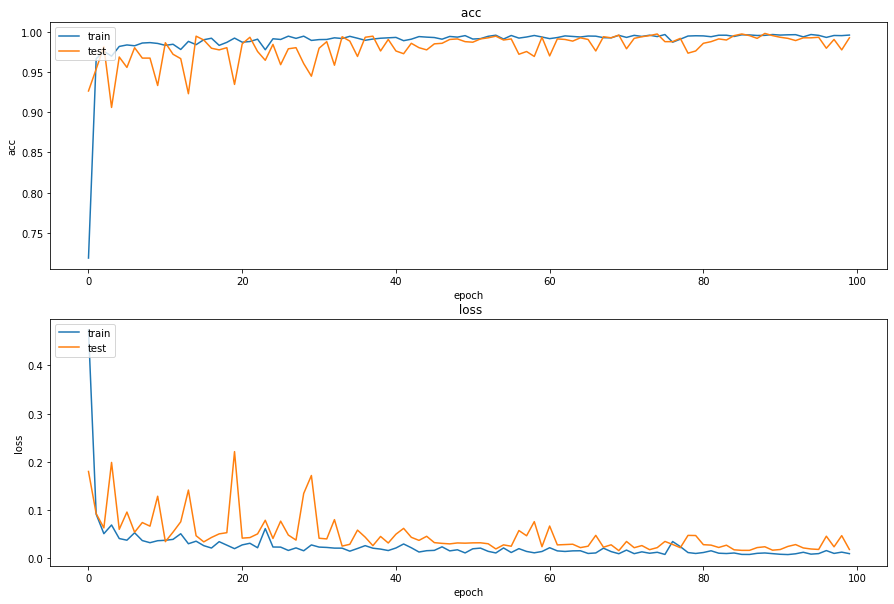

In [50]:

import matplotlib.pyplot as plt  
plt.figure(1, figsize=(15,10) )  


plt.subplot(211)  
plt.plot(model.history.history['acc'])  
plt.plot(model.history.history['val_acc'])  
plt.title(' acc')  
plt.ylabel('acc')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplot(212)  
plt.plot(model.history.history['loss'])  
plt.plot(model.history.history['val_loss'])  
plt.title(' loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [51]:
y_pred=model.predict(X_test)
rounded = np.round(y_pred)
rounded = rounded.reshape(-1)

[Text(0, 0.5, 'Down'), Text(0, 1.5, 'Up')]

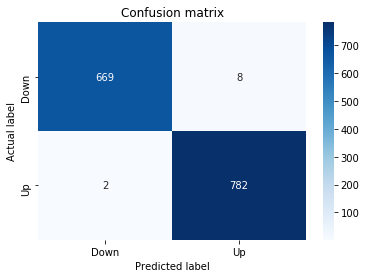

In [55]:
import sklearn.metrics as metrics
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(Y_test, rounded)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])